In [1]:
'''
Importa os módulos usados
'''
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
import math
import random
from collections import Counter
from scipy.optimize import minimize
from tqdm import tqdm
'''
Define um tipo de dado similar ao Pascal "record" or C "struct"
'''
clients = pd.read_csv(r'./clients.csv', header=None, names= ['x', 'y', 'consumo'])

class Struct:
    pass

In [2]:
def f1(y):
    return np.sum(y)

def f2(x):
    return np.sum(np.sum(d_i_j * x, axis=1))

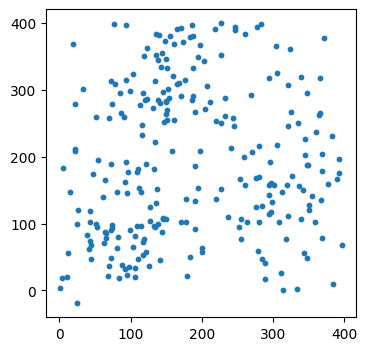

In [3]:
#Cria plot com as posições dos clientes
plt.figure(figsize=(4,4))
plt.scatter(clients['x'], clients['y'], s=10)

## Utilizando a meta-heurística GVNS

In [77]:
def distance(x1, y1, x2, y2) -> float:
    return math.sqrt((x2 - x1)**2 + (y2-y1)**2)


In [5]:
MULTIPLIER = 5

# Calcula o número de pontos em cada eixo (400 metros divididos por 5 metros por ponto)
num_points_x = int(400 / MULTIPLIER)
num_points_y = int(400 / MULTIPLIER)

# Crie um DataFrame vazio com as colunas necessárias
pas = pd.DataFrame(columns=['id', 'x', 'y', 'band', 'isActive'])
possible_coord = pd.DataFrame(columns=['x', 'y'])
coord_list = []

# Crie as coordenadas e adicione ao DataFrame
for i in range(1, num_points_x + 1):
    for u in range(1, num_points_y + 1):
        x_coord = MULTIPLIER * i
        y_coord = MULTIPLIER * u
        point_id = len(possible_coord) + 1  # ID do ponto
        coord_list.append(pd.DataFrame({
            'x': [x_coord],
            'y': [y_coord]
        }))

# Concatene a lista de DataFrames em um único DataFrame
possible_coord = pd.concat(coord_list, ignore_index=True)

In [17]:
pas_coords = []
for i in range(0,25):
    coord = random.randrange(1, 6400) - 1
    pas_coords.append(pd.DataFrame({
        'id': i,
        'x': [possible_coord['x'][coord]],
        'y': [possible_coord['y'][coord]],
        'isActive' : False,
        'band': 0
    }))

pas = pd.concat(pas_coords, ignore_index=True)

In [18]:
def filter_access_point(row: any, x: float, y: float, consumo: float, total_pa: int) -> None:
 
    if (row['band'] + consumo > 54 and (row['isActive'] == False and total_pa >= 25)):
        return math.inf
    
    return distance(float(row['x']), float(row['y']), float(x), float(y))

def nearest_avaliable_access_point(x: float, y: float, consumo: float)-> int:
    total_pa = len(pas[pas['isActive'] == True]['isActive'].tolist())
    pas['distance'] = pas.apply(lambda row: filter_access_point(row, x, y, consumo, total_pa), axis=1)
    nearest_access = pas.loc[pas['distance'].idxmin()]
    if nearest_access['distance'] < 70:
        pas.at[nearest_access['id'], 'band'] += consumo
        if nearest_access['isActive'] == False:
            pas.at[nearest_access['id'], 'isActive'] = True
            total_pa += 1
        return nearest_access['id']
    
    return -1

def init_solution() -> None:
    for index, row in clients.iterrows():
        nearest_access_point_id = nearest_avaliable_access_point(
            row['x'],
            row['y'],
            row['consumo'])
        clients.at[index, 'access_point'] = nearest_access_point_id

init_solution()
percent = len(clients[clients['access_point'] == -1]['access_point'].tolist()) * (100/256)
percent_pa = len(pas[pas['isActive'] == False]['isActive'].tolist()) * (100/25)

print(f'Percentual de usuários conectados: {100 - percent}%')
print(f'Percentual de PAs ativos: {100 - percent_pa}%')



Percentual de usuários conectados: 96.09375%
Percentual de PAs ativos: 100.0%


## Plota

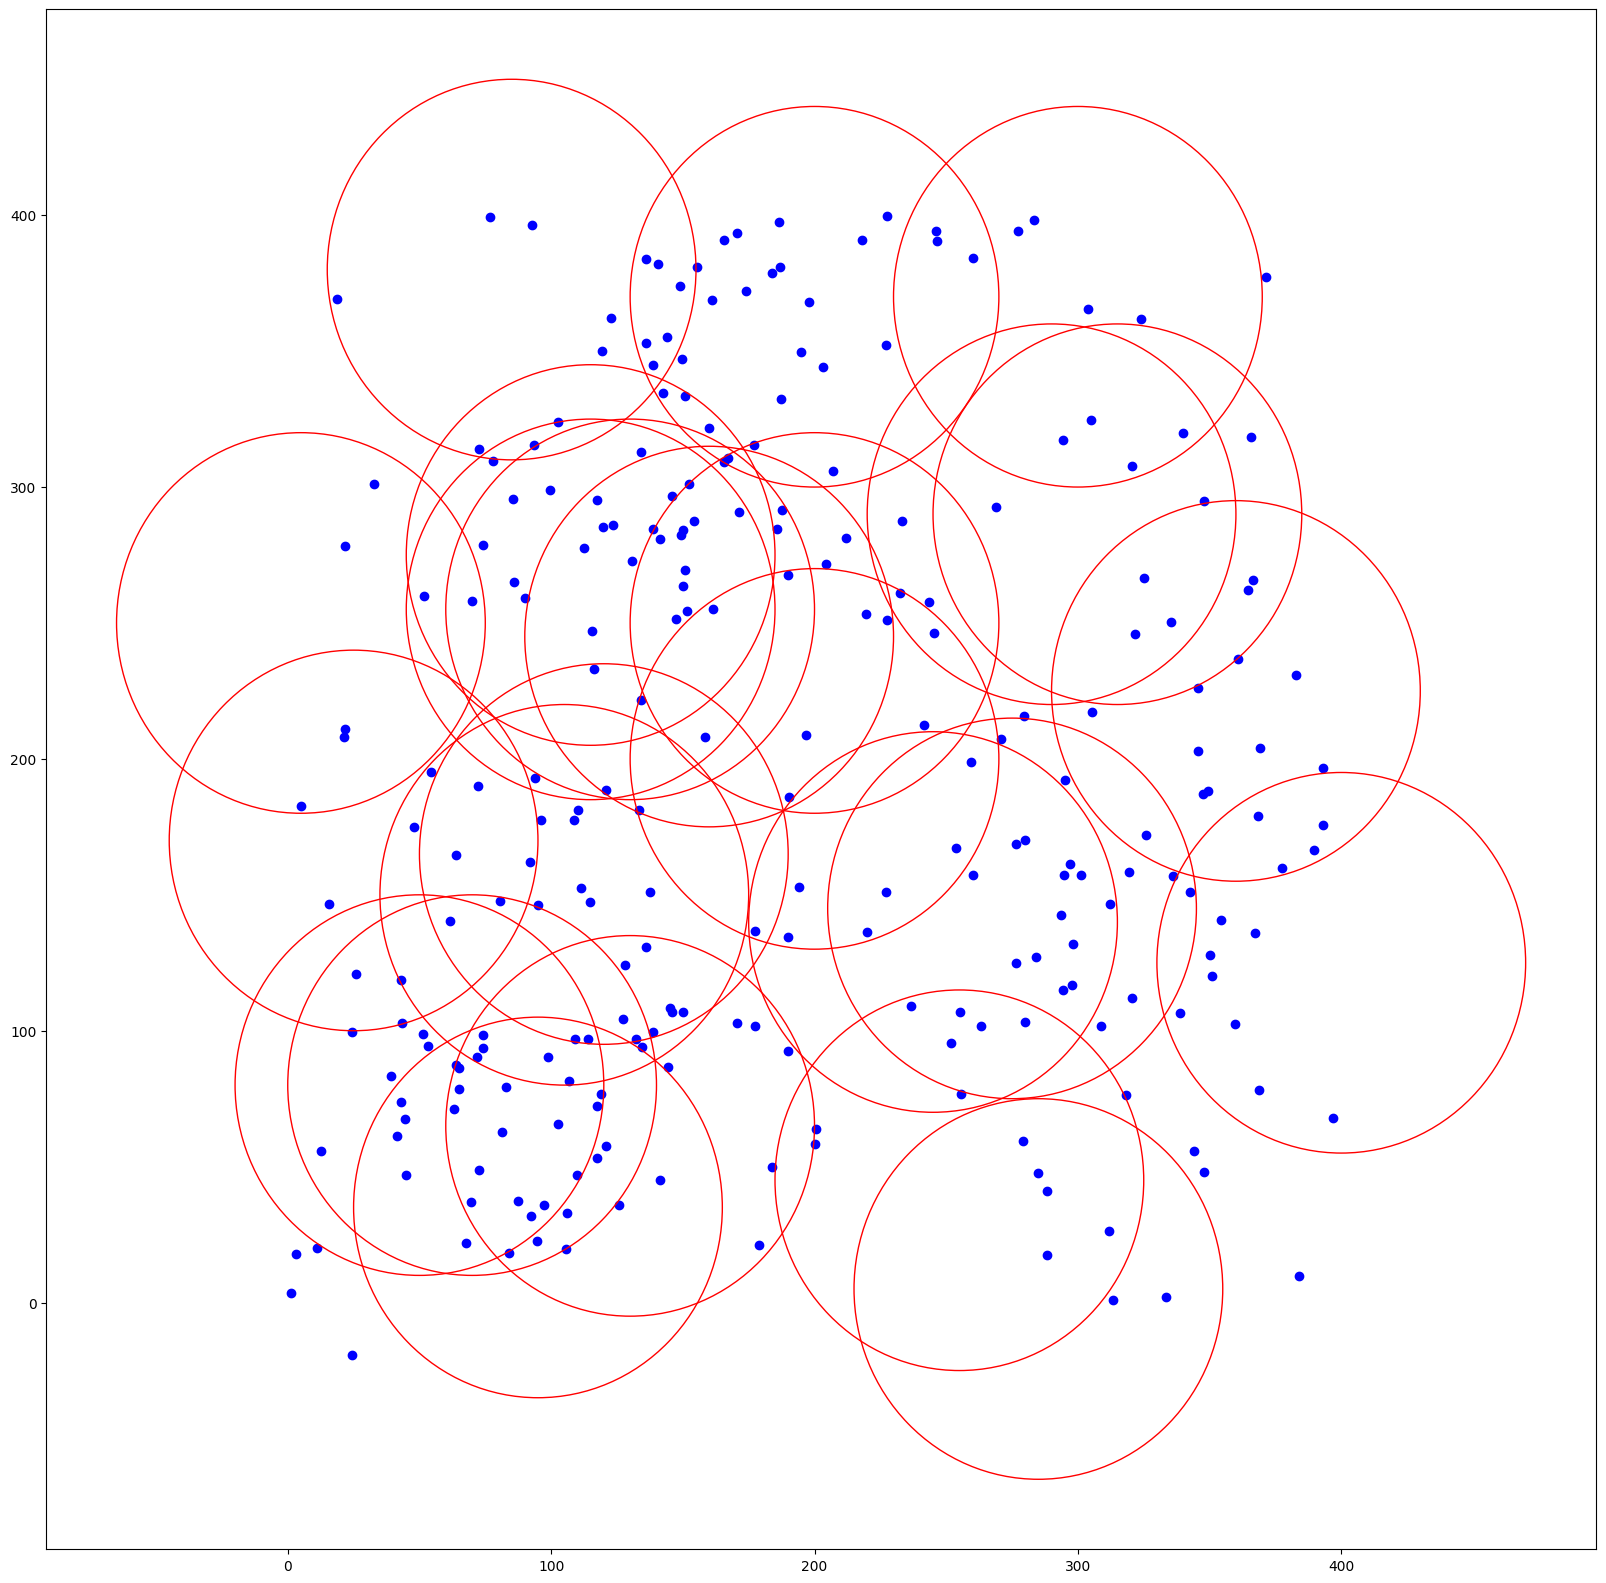

In [19]:
fig, ax = plt.subplots(figsize=(20,20))

ax.scatter(clients['x'], clients['y'], label='Users', color='blue', marker='o')

for index, row in pas.iterrows():
    ax.add_patch(plt.Circle((row['x'], row['y']), 70, fill=False, color="r"))

fig.savefig('plotcircles.png')

plt.show()

,id,x,y,isActive,band,distance
0,0,95,190,True,3.802214,100.382372
1,1,30,155,True,2.302454,117.667365
2,2,175,205,True,2.563398,116.345995
3,3,20,170,True,3.869614,134.022911
4,4,195,120,True,9.789948,66.896145
5,5,315,380,True,5.334851,337.049806
6,6,105,295,True,13.875194,200.076930
7,7,110,110,True,4.041891,25.885018
8,8,80,180,True,2.021661,98.260827
9,9,295,155,True,16.507408,172.837845


In [200]:
def shake(current_solution, current_pas):
 
    new_solution = current_solution.copy()
    print(new_solution)
    # Escolha aleatoriamente um ponto de entrega (PA) e um cliente
    i = random.randint(0, len(new_solution) - 1)
    j = random.randint(0, len(new_solution) - 1)
    
    pa_1 = random.choice(current_pas[current_pas['isActive'] == True]['id'].values) 
    pa_2 = random.choice(current_pas[current_pas['isActive'] == True]['id'].values) 
    
    # Troca o PA do cliente
    new_solution['access_point'][i] = pa_1
    new_solution['access_point'][j] = pa_2
    return new_solution
    

In [21]:
copy_p = pas.copy()
b = copy_p.drop(6, axis=0)
clients

,x,y,consumo,access_point
0,26.009434,120.889019,0.871185,19.0
1,102.717868,65.638131,0.893197,7.0
2,43.092319,73.625974,0.863030,19.0
3,73.944999,98.397250,1.349194,17.0
4,125.801223,35.921021,0.838093,7.0
...,...,...,...,...
251,350.123158,127.725057,0.773155,8.0
252,345.459075,202.909903,1.132448,4.0
253,122.917140,362.267394,1.028584,2.0
254,65.032794,86.218936,0.835895,17.0


In [22]:
DISTANCE = 'distance'

In [37]:
def calculate_band(b_c: float, b_pa: float):
    return b_c + b_pa < 54

def BestImprovement(x_i: pd.DataFrame, pas_t):
    x_icopy = x_i.copy()
    x_temp = x_icopy.copy()
    #print(len(pas_t))
    pas_copy = pas_t.copy()
    r1 = True
    counter = 0
    index_t, idx_t = 0, 0
    while r1:
        shortest_distance = 10000000
        pa_options = list(pas_copy['id'].values)
        i = random.choice(list(pas_copy['id'].values))
        if len(pa_options) <= 1:
            break
        pas_copy = pas_copy.drop(pas_copy[pas_copy['id'] == i].index)
        x_temp.loc[x_temp['access_point'] == i, 'access_point'] = -1
        pas_copy.loc[i, 'isActive'] = False
        for index, row in x_icopy.iterrows():
            if x_icopy['access_point'][index] == -1:
                for idx, r in pas_copy.iterrows():
                    dist = distance(
                        x_icopy['x'][index],
                        x_icopy['y'][index],
                        pas_copy['x'][idx],
                        pas_copy['y'][idx]
                        )
                    if (dist < shortest_distance) and calculate_band(x_icopy['consumo'][index], pas_copy['band'][idx]):
                        shortest_distance = dist
                        index_t, idx_t = index, idx
                        #x_temp['access_point'][index] = pas_copy['id'][idx]
                if shortest_distance < 70:
                    x_temp.loc[index_t, 'access_point'] = pas_copy.loc[idx_t, 'id']
                    x_temp.loc[index_t, DISTANCE] = shortest_distance
                    accumulated_band = pas_copy.loc[idx_t, 'band'] + x_temp.loc[index_t, 'consumo']
                    pas_copy.loc[idx_t, 'band'] = accumulated_band



        na_clients = len([value for value in x_temp['access_point'] if value == -1])
        r1 =  (na_clients*100 / len(clients)) <= 5

        if r1:
            x_icopy = x_temp.copy()
            pas_t = pas_copy.copy()

        counter += 1
    if len(x_icopy['access_point'].unique()) < len(x_i['access_point'].unique()):
        return x_icopy, pas_t
    else:
        return x_i, pas_t
    


In [24]:
clients_c = clients.copy()


In [25]:
for index, row in clients.iterrows():
    if clients['access_point'][index] != -1:
        clients.loc[index, DISTANCE] = distance(
            clients['x'][index],
            clients['y'][index],
            pas['x'][clients['access_point'][index]],
            pas['y'][clients['access_point'][index]]
        )
clients

,x,y,consumo,access_point,distance
0,26.009434,120.889019,0.871185,19.0,47.407374
1,102.717868,65.638131,0.893197,7.0,27.289594
2,43.092319,73.625974,0.863030,19.0,9.399163
3,73.944999,98.397250,1.349194,17.0,18.815468
4,125.801223,35.921021,0.838093,7.0,29.380551
...,...,...,...,...,...
251,350.123158,127.725057,0.773155,8.0,49.951230
252,345.459075,202.909903,1.132448,4.0,26.446377
253,122.917140,362.267394,1.028584,2.0,41.858748
254,65.032794,86.218936,0.835895,17.0,7.959164


## Estruturas de vizinhança


Para este caso, será empregado 3 tipos de Estruturas de vizinhança:
    Shift -> Trocar a posição de 3 PA's que estiverem conectados ao menor número de clientes
    Shift Posicional -> Trocar a Posição de PA's que estiverem muito próximos de outros PA's
    Delete -> Remover PA's com menor uso de banda

In [108]:
def ValidSol(x_ii_c: pd.DataFrame):
    na_clients = len([value for value in x_ii_c['distance'] if value < 70])
    return (na_clients*100 / len(x_ii_c)) <= 5

def MinSol(x_ii_c: pd.DataFrame, x_ii: pd.DataFrame) -> bool:
     l_c = list(x_ii_c['access_point'].unique())
     l_ii = list(x_ii['access_point'].unique())
     
     return len(l_c) < len(l_ii)
def NeighborhoodChange(x: pd.DataFrame, x_ii: pd.DataFrame, pa_t: pd.DataFrame, k):
    x_ii_copy = x_ii.copy()
    pa_t_copy = pa_t.copy()

    # Deactivate less connected PA's
    if k == 1:
        shortest_distance = 1000
        temp_clients = x_ii.copy()
        access_points_least_used = temp_clients['access_point'].tolist()
        least_common = int((Counter(access_points_least_used).most_common()[-1])[0])
        x_ii_copy.loc[x_ii_copy['access_point'] == least_common, 'access_point'] = -1
        pa_t_copy.loc[least_common, 'isActive'] = False
        for index, row in x_ii_copy.iterrows():
            if x_ii_copy['access_point'][index] == -1:
                for idx, r in pa_t_copy.iterrows():
                    dist = distance(
                        x_ii_copy['x'][index],
                        x_ii_copy['y'][index],
                        pa_t_copy['x'][idx],
                        pa_t_copy['y'][idx]
                    )
                    if dist < shortest_distance and calculate_band(x_ii_copy['consumo'][index], pa_t_copy['band'][idx]):
                        shortest_distance = dist
                        index_t, idx_t = index, idx

                if shortest_distance < 70:
                    x_ii_copy.loc[index_t, 'access_point'] = pa_t_copy.loc[idx_t, 'id']
                    x_ii_copy.loc[index_t, DISTANCE] = shortest_distance
                    accumulated_band = pa_t_copy.loc[idx_t, 'band'] + x_ii_copy.loc[index_t, 'consumo']
                    pa_t_copy.loc[idx_t, 'band'] = accumulated_band
                     

    if k == 2:         
        # Escolha aleatoriamente um ponto de entrega (PA) e um cliente
        i = random.randint(0, len(x_ii_copy) - 1)
        j = random.randint(0, len(x_ii_copy) - 1)
        
        pa_1 = random.choice(pa_t[pa_t['isActive'] == True]['id'].values) 
        pa_2 = random.choice(pa_t[pa_t['isActive'] == True]['id'].values) 
        
        # Troca o PA do cliente
        x_ii_copy.loc[i, 'access_point'] = pa_1
        x_ii_copy.loc[j, 'access_point'] = pa_2

    # Swap Two Clients
    if k == 3:        
        # Escolha aleatoriamente um ponto de entrega (PA) e um cliente
        i = random.randint(0, len(x_ii_copy) - 1)
        j = random.randint(0, len(x_ii_copy) - 1)
        
        

        t_hold = x_ii_copy['access_point'][i]
        x_ii_copy.loc[i, 'access_point'] = x_ii_copy['access_point'][j]
        x_ii_copy.loc[j, 'access_point'] = t_hold
        
    if ValidSol(x_ii_copy) and MinSol(x_ii_copy, x_ii):
        x_ii = x_ii_copy.copy()
        pa_t = pa_t_copy.copy()
    else:
        k += 1
    
    return x_ii, k, pa_t


In [27]:
pas_t = pas.copy()
a = clients.copy()
for i in range(0, 5000):
    a = shake(a, pas_t)
    pas_t = pas[pas['id'].isin(list(a['access_point'].unique()))]
    true_items = [value for value in a['access_point'] if value == -1]
    #len(true_items)
    a, pas_t = BestImprovement(a, pas_t)
    l = list(a['access_point'].unique())
    #print(len(pas_t))
a

,x,y,consumo,access_point,distance
0,26.009434,120.889019,0.871185,11.0,47.407374
1,102.717868,65.638131,0.893197,8.0,27.289594
2,43.092319,73.625974,0.863030,8.0,9.399163
3,73.944999,98.397250,1.349194,0.0,30.196387
4,125.801223,35.921021,0.838093,18.0,29.380551
...,...,...,...,...,...
251,350.123158,127.725057,0.773155,11.0,49.951230
252,345.459075,202.909903,1.132448,13.0,26.446377
253,122.917140,362.267394,1.028584,18.0,41.858748
254,65.032794,86.218936,0.835895,19.0,7.959164


In [28]:

l = list(a['access_point'].unique())
l.sort()
total_consume = a['consumo'].sum()
total_band = pas_t['band'].sum()
print(len(l))
print(total_consume)
print(total_band)
pas_t

13
191.89247486032656
105.38692360542422


,id,x,y,isActive,band,distance
0,0,245,140,True,5.578076,120.737581
2,2,85,380,True,6.042988,287.127279
3,3,95,35,True,6.741913,72.153635
6,6,255,45,True,4.064124,133.218763
7,7,130,65,True,18.121687,31.869015
8,8,400,125,True,8.898179,269.222386
10,10,120,165,True,6.006251,69.304191
11,11,275,145,True,15.774907,150.662166
13,13,5,250,True,2.971703,199.170096
18,18,115,255,True,4.049778,159.149885


In [29]:
C_MAX = 1000
def bvns():
    c = 0
    pas_copy = pas.copy()
    x = clients.copy()
    for c in tqdm(range(0, C_MAX)):
        k = 1
        while k < 3:
            #print(k)
            x_i = shake(x, pas_copy)
            x_ii, pas_copy = BestImprovement(x_i, pas_copy)
            x, k, pas_copy = NeighborhoodChange(x, x_ii, pas_copy, k)
            l = list(x['access_point'].unique())
            l.sort()
           #print(len(l))
        #print(f'Iteração: {c}\n')
    return x, pas_copy


In [30]:
pas_t = pas.copy()
a = clients.copy()
a, pa_t = bvns()
a

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:33<00:00, 10.72it/s]


,x,y,consumo,access_point,distance
0,26.009434,120.889019,0.871185,0.0,47.407374
1,102.717868,65.638131,0.893197,12.0,27.289594
2,43.092319,73.625974,0.863030,0.0,9.399163
3,73.944999,98.397250,1.349194,17.0,18.815468
4,125.801223,35.921021,0.838093,9.0,29.380551
...,...,...,...,...,...
251,350.123158,127.725057,0.773155,6.0,49.951230
252,345.459075,202.909903,1.132448,1.0,26.446377
253,122.917140,362.267394,1.028584,22.0,41.858748
254,65.032794,86.218936,0.835895,22.0,7.959164


In [34]:

l = list(a['access_point'].unique())
l.sort()
l
percent = len(a[a['access_point'] == -1]['access_point'].tolist()) * (100/256)
percent_pa = len(pa_t[pa_t['isActive'] == False]['isActive'].tolist()) * (100/25)

print(f'Percentual de usuários conectados: {100 - percent}%')
print(f'Percentual de PAs ativos: {100 - percent_pa}%')

len(a[a['distance'] > 70])


Percentual de usuários conectados: 100.0%
Percentual de PAs ativos: 40.0%


0

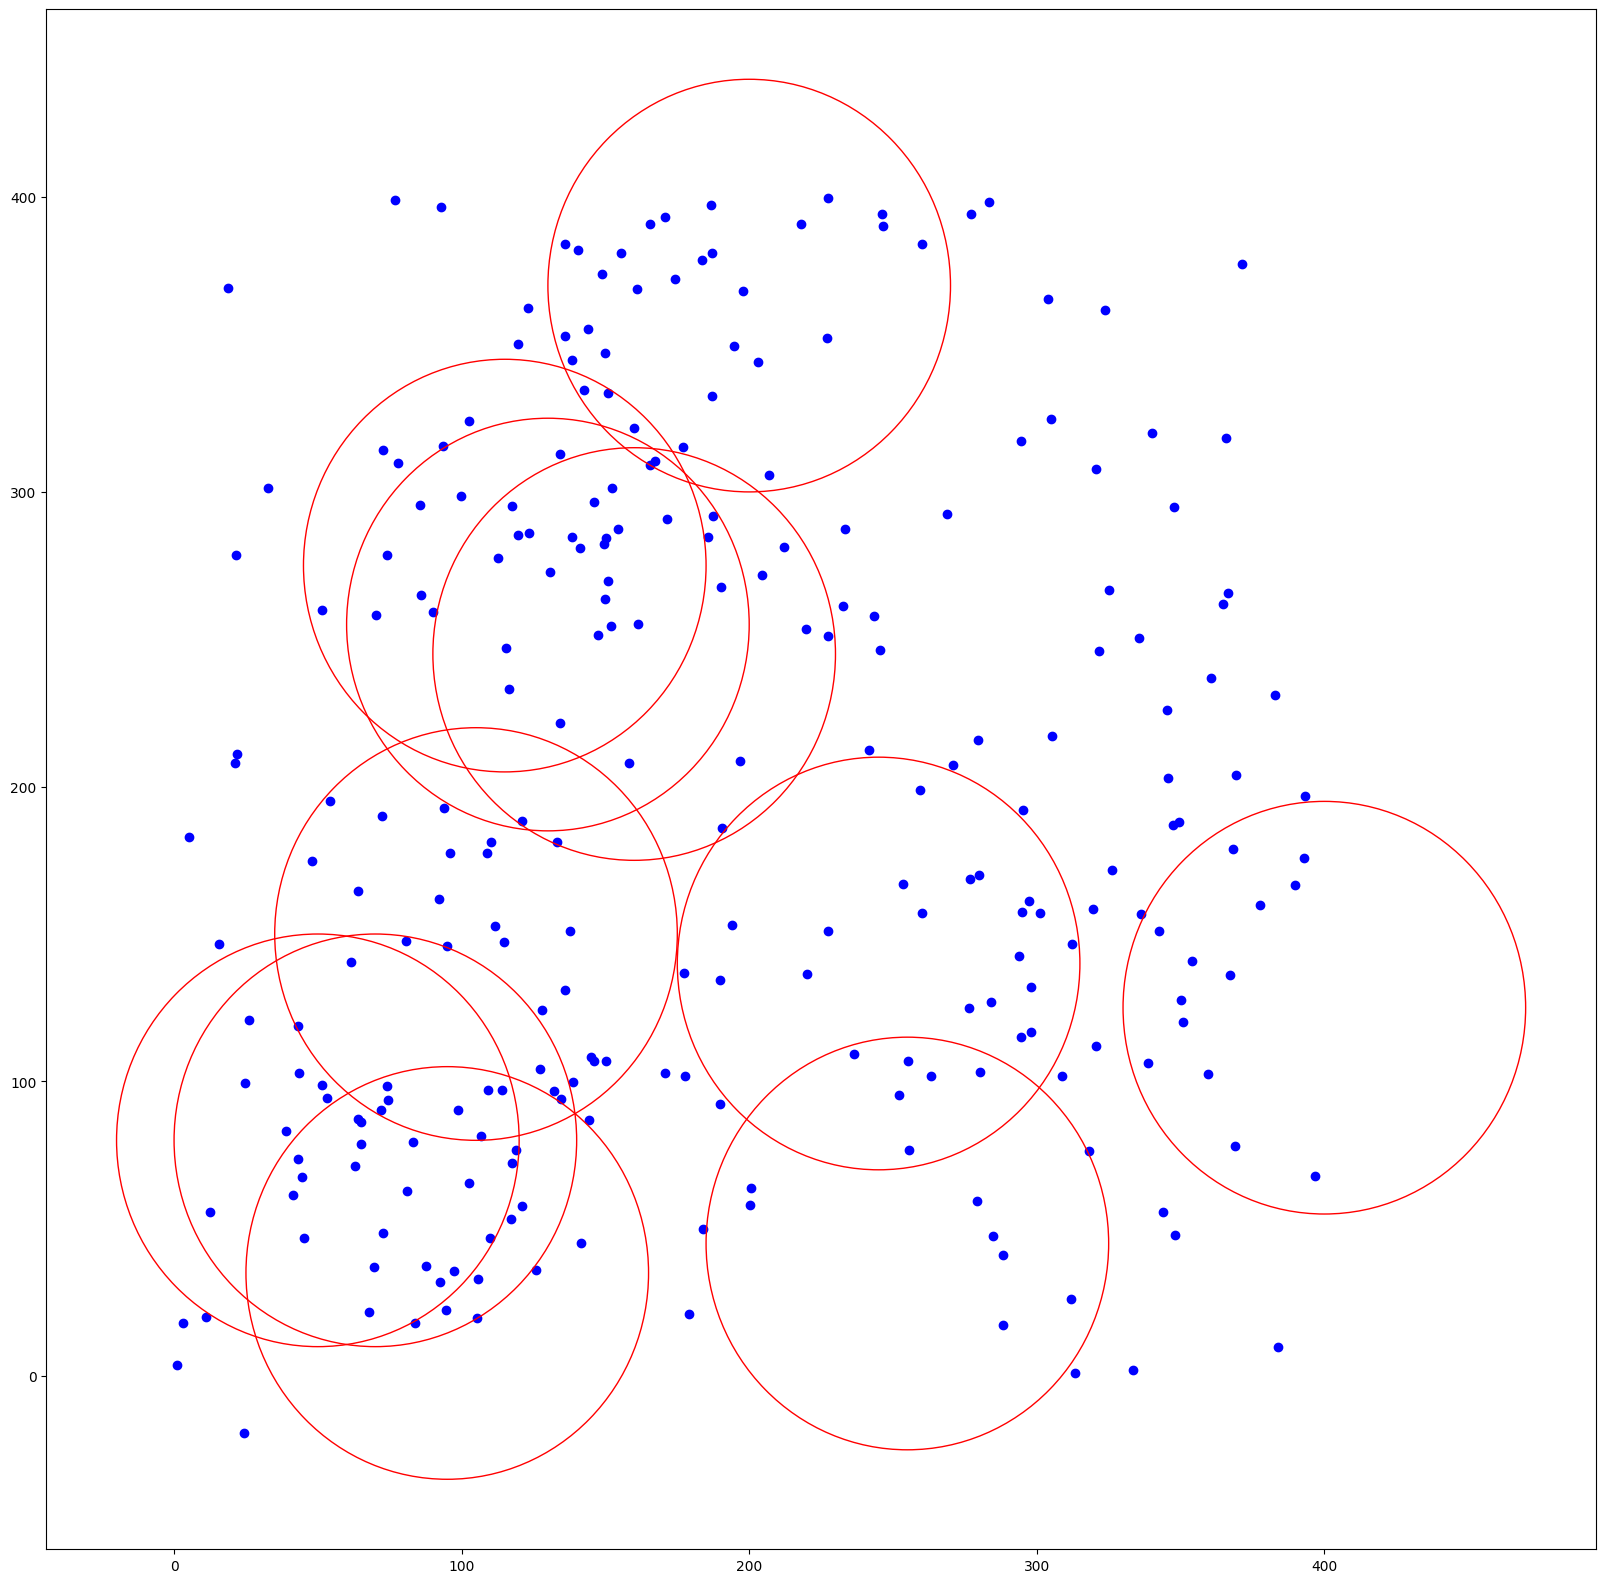

In [35]:
fig, ax = plt.subplots(figsize=(20,20))

ax.scatter(a['x'], a['y'], label='Users', color='blue', marker='o')

for index, row in pa_t.iterrows():
    if row['isActive']:
        ax.add_patch(plt.Circle((row['x'], row['y']), 70, fill=False, color="r"))

fig.savefig('plotcircles.png')

plt.show()

## Otimização F2


Implementação do Best Improvement

In [107]:
def search_nearest_pa(x: float, y: float, consume: float, pas_t: pd.DataFrame) -> int:
    shortest_distance = 50000 
    pas_id = 0
    for index, row in pas_t.iterrows():
        t_distance = distance(x, y, pas_t['x'][index], pas_t['y'][index])
        if t_distance < shortest_distance and (consume + pas_t['band'][index] <= 54):
            shortest_distance = t_distance
            pas_id = pas_t['id'][index]

    if shortest_distance > 70:
        pas_id = -1

    return pas_id

def calculate_band(b_c: float, b_pa: float):
    return b_c + b_pa < 54

def BestImprovementF2(x_i: pd.DataFrame, pas_t):
    x_icopy = x_i.copy()
    x_temp = x_icopy.copy()
    pas_copy = pas_t.copy()
    r1 = True
    counter = 0
    index_t, idx_t = 0, 0
    for index, row in x_temp.iterrows():
        pas_id = search_nearest_pa(
            x_temp['x'][index], 
            x_temp['y'][index], 
            x_temp['consumo'][index], 
            pas_copy
            )
        if pas_id != -1:
            pas_id = int(pas_id)
            x_temp.at[index, 'access_point'] = pas_id
            pas_copy.at[pas_id, 'band'] += x_temp.at[index, 'consumo'] 


    return x_icopy, pas_copy


## Estruturas de Vizinhança

In [97]:
pas_t2 = pas.copy()
a2 = clients.copy()
print(a2['distance'].sum())
a2, pas_t2 = BestImprovementF2(a2, pas_t2)
print(a2['distance'].sum())
a2

8328.303425009542
Pas Id is: 19
8.820862467312285
9.692047508269006
Pas Id is: 7
18.121687035590394
19.014884073772766
Pas Id is: 19
9.692047508269006
10.555077972864673
Pas Id is: 17
7.8517249743961415
9.200918888658713
Pas Id is: 7
19.014884073772766
19.85297740163783
Pas Id is: 7
19.85297740163783
20.028792689130924
Pas Id is: 7
20.028792689130924
20.288650201811095
Pas Id is: 17
9.200918888658713
10.294632664292232
Pas Id is: 7
20.288650201811095
20.389524372431186
Pas Id is: 1
5.617930564948141
5.746864728416952
Pas Id is: -1
Pas Id is: 21
8.193728978706249
9.213823207839631
Pas Id is: 7
20.389524372431186
21.692935488429463
Pas Id is: 1
5.746864728416952
6.063532814305108
Pas Id is: 10
6.00625054554944
6.657978633813956
Pas Id is: 19
10.555077972864673
11.973521677799436
Pas Id is: 19
11.973521677799436
12.154623829445075
Pas Id is: 21
9.213823207839631
10.58781170201937
Pas Id is: 3
6.7419129462148195
8.012299517869602
Pas Id is: 7
21.692935488429463
22.51386419969443
Pas Id is:

,id,x,y,isActive,band,distance
0,0,245,140,True,11.156153,120.737581
1,1,105,150,True,11.235861,59.787360
2,2,85,380,True,12.085976,287.127279
3,3,95,35,True,13.483826,72.153635
4,4,360,225,True,20.052708,261.349798
5,5,300,370,True,8.370572,320.594980
6,6,255,45,True,8.128248,133.218763
7,7,130,65,True,36.243374,31.869015
8,8,400,125,True,17.796358,269.222386
9,9,200,370,True,30.190882,281.483745


In [100]:
C_MAX = 1000
def bvnsF2():
    c = 0
    pas_copy = pas.copy()
    x = clients.copy()
    for c in tqdm(range(0, C_MAX)):
        k = 1
        while k < 3:
            #print(k)
            x_i = shake(x, pas_copy)
            x_ii, pas_copy = BestImprovementF2(x_i, pas_copy)
            x, k, pas_copy = NeighborhoodChange(x, x_ii, pas_copy, k)
            l = list(x['access_point'].unique())
            l.sort()
           #print(len(l))
        #print(f'Iteração: {c}\n')
    return x, pas_copy


In [109]:
pas_t = pas.copy()
a = clients.copy()
a, pa_t = bvnsF2()
a

100%|██████████| 1000/1000 [09:55<00:00,  1.68it/s]


,x,y,consumo,access_point,distance
0,26.009434,120.889019,0.871185,19.0,47.407374
1,102.717868,65.638131,0.893197,16.0,27.289594
2,43.092319,73.625974,0.863030,5.0,9.399163
3,73.944999,98.397250,1.349194,18.0,18.815468
4,125.801223,35.921021,0.838093,9.0,29.380551
...,...,...,...,...,...
251,350.123158,127.725057,0.773155,21.0,49.951230
252,345.459075,202.909903,1.132448,1.0,26.446377
253,122.917140,362.267394,1.028584,20.0,41.858748
254,65.032794,86.218936,0.835895,6.0,7.959164


In [141]:
class Client:
    def __init__(self, id: int, coord: list, access_point: int, consume: float, distance_from_pa : int = 0) -> None:
        self._id = id
        self._coord = coord
        self._consume = consume
        self._distance_from_pa = distance_from_pa

    def get_from_df_row(self, row: pd.DataFrame) -> None:
        return Client(
            [row['x'], row['y']],
            consume= row['consumo']
        )
    
    def __calculate_distance_from_pa(self) -> None:
        return distance(
            self._coord[0],
            self._coord[1],
            self._pa.x,
            self._pa.y
        )

    def define_client_pa(self, pa : AccessPoint) -> None:
       
        if self.__calculate_distance_from_pa() > 70:
            print('Distance from PA exceds the minimum value accepted')
            self._pa = AccessPoint(None)


class AccessPoint:

    def __init__(self, id: int, coord: tuple, band: float = 54, is_active: bool = True) -> None:
        self.is_active = is_active
        self._id = id
        self._coord = coord
        self.band = band

    @staticmethod    
    def get_from_row(row: pd.DataFrame, index: int) -> None:
        return AccessPoint(
            index + 1,
            (row['x'], row['y'])
            )
    
    def check_activity(self) -> None:
        if len(self.clients) == 0:
            self.is_active = False
    
    def __calculate_distance_from_client(self, client_coord: Client) -> None:
            return math.sqrt(
                (client_coord[0] - self.coord[0])**2 + 
                (client_coord[1] - self.coord[1])**2
                )


    def assign_client(self, client: Client) -> None:
        distance = self.__calculate_distance_from_client(self._coord, client.coord)
        remaining_band = self.band - client.consume
        if distance < 70 and remaining_band > 0:
            self.clients.append(client)
            client._distance_from_pa = distance
        else:
            print('Requirements not satisfied')






In [146]:
model_pas = [AccessPoint.get_from_row(row, index)
             for index, row in pas.iterrows()]

model_pas[0]._coord

(245, 140)

In [147]:
probdata = Struct()
ids = list(np.arange(1, 256))
probdata.x = clients['x']
probdata.y = clients['y']
probdata.id = ids

In [161]:
def pw_function(x: pd.DataFrame, approach: list)-> None:
    f1 = len(list(x['access_point'].unique()))
    f2 = x['distance'].sum()
    return (approach[0] * f1) + (approach[1] *f2)

In [179]:
def bvns_approach_multiobjective(objective_function, x, approachinfo, maxeval=1000):
    c = 0
    pas_copy = pas.copy()
    x_copy = clients.copy()
    for c in tqdm(range(maxeval)):
        k = 1
        while k < 3:
            x_i = shake(x_copy, pas_copy)
            x_ii, pas_copy = BestImprovement(x_i, pas_copy)
            print(x_i)
            # Avaliação das funções objetivas
            x_i_result = objective_function(x_ii, approachinfo)
            
            # Atualização da solução baseada na busca local
            x, k, pas_copy = NeighborhoodChange(x_copy, x_ii, pas_copy, k)
            x_result = objective_function(x, approachinfo)
        # Atualização da solução global se uma solução melhor foi encontrada
        if x_i_result < x_result:
            x = x_i.copy()

    return x, pas_copy

In [ ]:
archive = Struct()
archive.g = []
archive.sol = []
archive.fitpen = []

# Armazena dados da estratégia de otimização mono-objetivo
approachinfo = Struct()
pas_t = pas.copy()
x = clients.copy()

N = 1                                      # número desejado de soluções Pareto-ótimas ESTIMADAS
for i in np.arange(0,N,1):                 # cada iteração mapeia uma solução na fronteira estimada
    
    w = np.random.random(size=2)           # gera um vetor de pesos aleatórios
    w = w/sum(w)                           # normaliza o vetor de pesos (i.e., sum(w) = 1)
    
    # Gera solução inicial    
    approachinfo.w = w
    x = bvns_approach_multiobjective(pw_function, x, w, maxeval=1000)

    
    
    # archive.g.append(x.g)
    # archive.sol.append(x.solution)
    # archive.fitpen.append(x.fitness_penalizado)


# f = np.array(archive.fitpen)
# g = np.array(archive.g)
# F = copy.deepcopy(f[g<=0,:])        # faz uma cópia somente das soluções viáveis
# NDindex = nondominatedsolutions(F)  # índices das soluções não-dominadas  

x


In [231]:
"""
@author: Lucas S Batista
"""


'''
Importa os módulos usados
'''
import numpy as np
import copy
import random 
import pandas as pd
from collections import Counter
import math

DISTANCE = 'distance'

def calculate_band(b_c: float, b_pa: float):
    return b_c + b_pa < 54

def BestImprovement(x_i: pd.DataFrame, pas_t, approach):
    x_icopy = x_i.copy()
    x_temp = x_icopy.copy()
    #print(len(pas_t))
    pas_copy = pas_t.copy()
    r1 = True
    counter = 0
    index_t, idx_t = 0, 0
    while r1:
        shortest_distance = 10000000
        pa_options = list(pas_copy['id'].values)
        i = random.choice(list(pas_copy['id'].values))
        if len(pa_options) <= 1:
            break
        pas_copy = pas_copy.drop(pas_copy[pas_copy['id'] == i].index)
        x_temp.loc[x_temp['access_point'] == i, 'access_point'] = -1
        pas_copy.loc[i, 'isActive'] = False
        for index, row in x_icopy.iterrows():
            if x_icopy['access_point'][index] == -1:
                for idx, r in pas_copy.iterrows():
                    dist = distance(
                        x_icopy['x'][index],
                        x_icopy['y'][index],
                        pas_copy['x'][idx],
                        pas_copy['y'][idx]
                        )
                    if (dist < shortest_distance) and calculate_band(x_icopy['consumo'][index], pas_copy['band'][idx]):
                        shortest_distance = dist
                        index_t, idx_t = index, idx
                        #x_temp['access_point'][index] = pas_copy['id'][idx]
                if shortest_distance < 70:
                    x_temp.loc[index_t, 'access_point'] = pas_copy.loc[idx_t, 'id']
                    x_temp.loc[index_t, DISTANCE] = shortest_distance
                    accumulated_band = pas_copy.loc[idx_t, 'band'] + x_temp.loc[index_t, 'consumo']
                    pas_copy.loc[idx_t, 'band'] = accumulated_band



        na_clients = len([value for value in x_temp['access_point'] if value == -1])
        r1 =  (na_clients*100 / len(clients)) <= 5

        if r1:
            x_icopy = x_temp.copy()
            pas_t = pas_copy.copy()

        counter += 1
    if pw_function(x_icopy, approach)[0] < pw_function(x_i, approach)[0]:
        return x_icopy, pas_t
    else:
        return x_i, pas_t
    


def shake(current_solution, current_pas):
 
    new_solution = current_solution.copy()
    
    # Escolha aleatoriamente um ponto de entrega (PA) e um cliente
    i = random.randint(0, len(new_solution) - 1)
    j = random.randint(0, len(new_solution) - 1)
    
    pa_1 = random.choice(current_pas[current_pas['isActive'] == True]['id'].values) 
    pa_2 = random.choice(current_pas[current_pas['isActive'] == True]['id'].values) 
    
    # Troca o PA do cliente
    new_solution['access_point'][i] = pa_1
    new_solution['access_point'][j] = pa_2
    return new_solution
    

def distance(x1, y1, x2, y2) -> float:
    return math.sqrt((x2 - x1)**2 + (y2-y1)**2)

def calculate_band(b_c: float, b_pa: float):
    return b_c + b_pa < 54

def ValidSol(x_ii_c: pd.DataFrame):
    na_clients = len([value for value in x_ii_c['distance'] if value < 70])
    return (na_clients*100 / len(x_ii_c)) <= 5

def MinSol(x_ii_c: pd.DataFrame, x_ii: pd.DataFrame) -> bool:
     l_c = list(x_ii_c['access_point'].unique())
     l_ii = list(x_ii['access_point'].unique())
     
     return len(l_c) < len(l_ii)

def NeighborhoodChange(x: pd.DataFrame, x_ii: pd.DataFrame, pa_t: pd.DataFrame, obj_function, approachinfo, k: int):
    x_ii_copy = x_ii.copy()
    pa_t_copy = pa_t.copy()

    # Deactivate less connected PA's
    if k == 1:
        shortest_distance = 1000
        temp_clients = x_ii.copy()
        access_points_least_used = temp_clients['access_point'].tolist()
        least_common = int((Counter(access_points_least_used).most_common()[-1])[0])
        x_ii_copy.loc[x_ii_copy['access_point'] == least_common, 'access_point'] = -1
        pa_t_copy.loc[least_common, 'isActive'] = False
        for index, row in x_ii_copy.iterrows():
            if x_ii_copy['access_point'][index] == -1:
                for idx, r in pa_t_copy.iterrows():
                    dist = distance(
                        x_ii_copy['x'][index],
                        x_ii_copy['y'][index],
                        pa_t_copy['x'][idx],
                        pa_t_copy['y'][idx]
                    )
                    if dist < shortest_distance and calculate_band(x_ii_copy['consumo'][index], pa_t_copy['band'][idx]):
                        shortest_distance = dist
                        index_t, idx_t = index, idx

                if shortest_distance < 70:
                    x_ii_copy.loc[index_t, 'access_point'] = pa_t_copy.loc[idx_t, 'id']
                    x_ii_copy.loc[index_t, DISTANCE] = shortest_distance
                    accumulated_band = pa_t_copy.loc[idx_t, 'band'] + x_ii_copy.loc[index_t, 'consumo']
                    pa_t_copy.loc[idx_t, 'band'] = accumulated_band
                     

    if k == 2:         
        # Escolha aleatoriamente um ponto de entrega (PA) e um cliente
        i = random.randint(0, len(x_ii_copy) - 1)
        j = random.randint(0, len(x_ii_copy) - 1)
        
        pa_1 = random.choice(pa_t[pa_t['isActive'] == True]['id'].values) 
        pa_2 = random.choice(pa_t[pa_t['isActive'] == True]['id'].values) 
        
        # Troca o PA do cliente
        x_ii_copy.loc[i, 'access_point'] = pa_1
        x_ii_copy.loc[j, 'access_point'] = pa_2

    # Swap Two Clients
    if k == 3:        
        # Escolha aleatoriamente um ponto de entrega (PA) e um cliente
        i = random.randint(0, len(x_ii_copy) - 1)
        j = random.randint(0, len(x_ii_copy) - 1)
        
        

        t_hold = x_ii_copy['access_point'][i]
        x_ii_copy.loc[i, 'access_point'] = x_ii_copy['access_point'][j]
        x_ii_copy.loc[j, 'access_point'] = t_hold
    
    if obj_function(x_ii, approachinfo) < obj_function(x, approachinfo):
        x = x_ii
        k += 1
        pa_t = pa_t_copy

    
    return x_ii, k, pa_t

'''
Implementa a função shake
'''
# def shake(x,k,probdata):
    
#     y = copy.deepcopy(x)
#     r = np.random.permutation(probdata.n)       
    
#     if k == 1:             # apply not operator in one random position
#         y.solution[r[0]] = not(y.solution[r[0]])
        
#     elif k == 2:           # apply not operator in two random positions        
#         y.solution[r[0]] = not(y.solution[r[0]])
#         y.solution[r[1]] = not(y.solution[r[1]])
        
#     elif k == 3:           # apply not operator in three random positions
#         y.solution[r[0]] = not(y.solution[r[0]])
#         y.solution[r[1]] = not(y.solution[r[1]])
#         y.solution[r[2]] = not(y.solution[r[2]])        
    
#     return y

'''
Implementa a função neighborhoodChange
'''

def pw_function(x: pd.DataFrame, approach: list)-> None:
    f1 = len(list(x['access_point'].unique()))
    f2 = x['distance'].sum()
    w_x = (approach[0] * f1)
    w_y = (approach[1] *f2)
    return w_x + w_y, w_x, w_y 


def neighborhoodChange(x, y, k):
    
    if y.single_objective_value < x.single_objective_value:
        x = copy.deepcopy(y)
        k = 1
    else:
        k += 1
        
    return x, k


'''
Implementa uma metaheurística RVNS
'''
def rvns_approach(fobj,x,probdata,approachinfo,maxeval=1000):
    
    # Contador do número de soluções candidatas avaliadas
    num_sol_avaliadas = 0

    # Máximo número de soluções candidatas avaliadas
    max_num_sol_avaliadas = maxeval

    # Número de estruturas de vizinhanças definidas
    kmax = 3
       
    # Avalia solução inicial
    x = fobj(x,approachinfo,probdata)
    num_sol_avaliadas += 1
    
    
    # Ciclo iterativo do método
    while num_sol_avaliadas < max_num_sol_avaliadas:

        k = 1
        while k <= kmax:

            # Gera uma solução candidata na k-ésima vizinhança de x          
            y = shake(x,k,probdata)
            y = fobj(y,approachinfo,probdata)
            num_sol_avaliadas += 1

            # Atualiza solução corrente e estrutura de vizinhança (se necessário)
            x, k = neighborhoodChange(x, y, k)
    
    return x


def vns_approach(fobj, x, pas, approachinfo, maxeval=1000):
    # Contador do número de soluções candidatas avaliadas
    num_sol_avaliadas = 0

    # Máximo número de soluções candidatas avaliadas
    max_num_sol_avaliadas = maxeval

    # Sequência fixa de vizinhanças
    neighborhoods = [1, 2, 3]  # Adapte de acordo com suas necessidades

    # Avalia solução inicial
    x_result = fobj(x, approachinfo)
    num_sol_avaliadas += 1
    c = 0
    pas_copy = pas.copy()
    
    # Ciclo iterativo do método
    for c in tqdm(range(0, max_num_sol_avaliadas)):

        for k in range(1,3):
            # Gera uma solução candidata na k-ésima vizinhança de x
            y_i = shake(x, pas_copy)
            y_ii, pas_copy = BestImprovement(y_i, pas_copy, approachinfo)

            # Atualiza solução corrente e estrutura de vizinhança (se necessário)
            x, k, _ = NeighborhoodChange(x, y_ii, pas_copy, fobj, approachinfo, k)  # 0 indica que não houve mudança na vizinhança

    return x


In [240]:
c = 0
pas_copy = pas.copy()
x = clients.copy()
N = 10                                    # número desejado de soluções Pareto-ótimas ESTIMADAS
for i in np.arange(0,N,1):                 # cada iteração mapeia uma solução na fronteira estimada
    
    w = np.random.random(size=2)  # gera um vetor de pesos aleatórios
    w = w/sum(w)                           # normaliza o vetor de pesos (i.e., sum(w) = 1)
        
    x = vns_approach(pw_function, x, pas_copy, w, maxeval=1000)
    _, s1, s2 = pw_function(x, w)
    
    archive.fitpen.append([s1,s2])

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:07<00:00,  7.85it/s]


In [241]:

l = list(x['access_point'].unique())
l.sort()
total_consume = x['consumo'].sum()
total_band = pas_t['band'].sum()
print(f'Quantidade de PAs utilizados: {len(l)}')

# print(total_consume)
# print(total_band)
print(x['distance'].sum())
pas_t

Quantidade de PAs utilizados: 8
8328.303425009542


,id,x,y,isActive,band,distance
0,0,245,140,True,5.578076,120.737581
1,1,105,150,True,5.617931,59.787360
2,2,85,380,True,6.042988,287.127279
3,3,95,35,True,6.741913,72.153635
4,4,360,225,True,10.026354,261.349798
5,5,300,370,True,4.185286,320.594980
6,6,255,45,True,4.064124,133.218763
7,7,130,65,True,18.121687,31.869015
8,8,400,125,True,8.898179,269.222386
9,9,200,370,True,15.095441,281.483745


In [234]:
'''
Implementa a função 'non-dominated sorting' (considera minimização)
'''
def nondominatedsolutions(f):
    
    N = np.shape(f)[0]    
    nondominatedsolindex = np.ones(N,dtype=int)  # armazena o índice das soluções não-dominadas
    for i in np.arange(0,N,1):
        for j in np.arange(0,N,1):
            if j == i:
                continue
            if np.all(np.array(f[j,:]) <= np.array(f[i,:]))==True and np.any(np.array(f[j,:]) < np.array(f[i,:]))==True:
                nondominatedsolindex[i] = 0  # solução i é dominada
                break
        
    return nondominatedsolindex

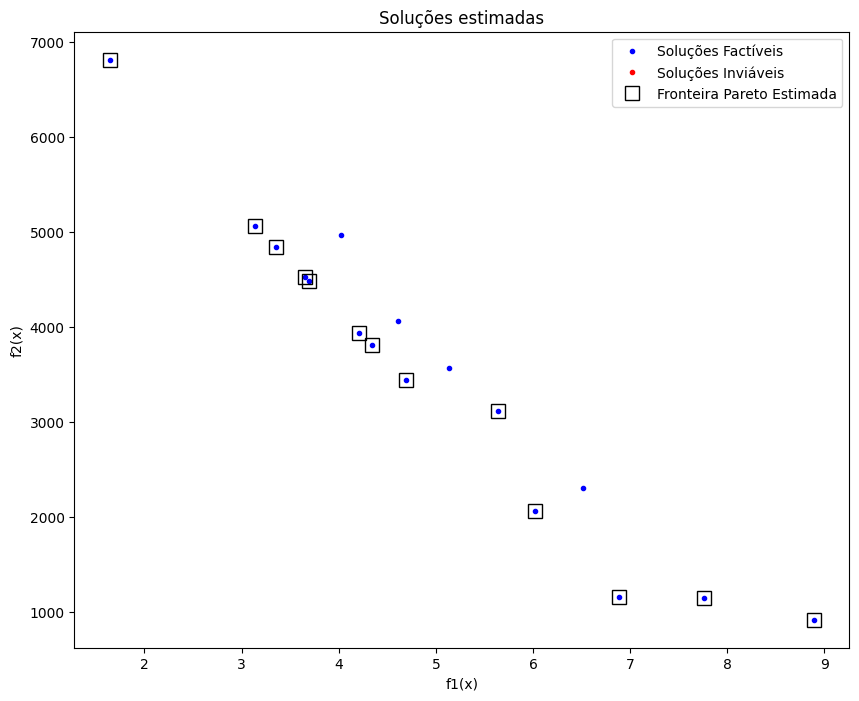

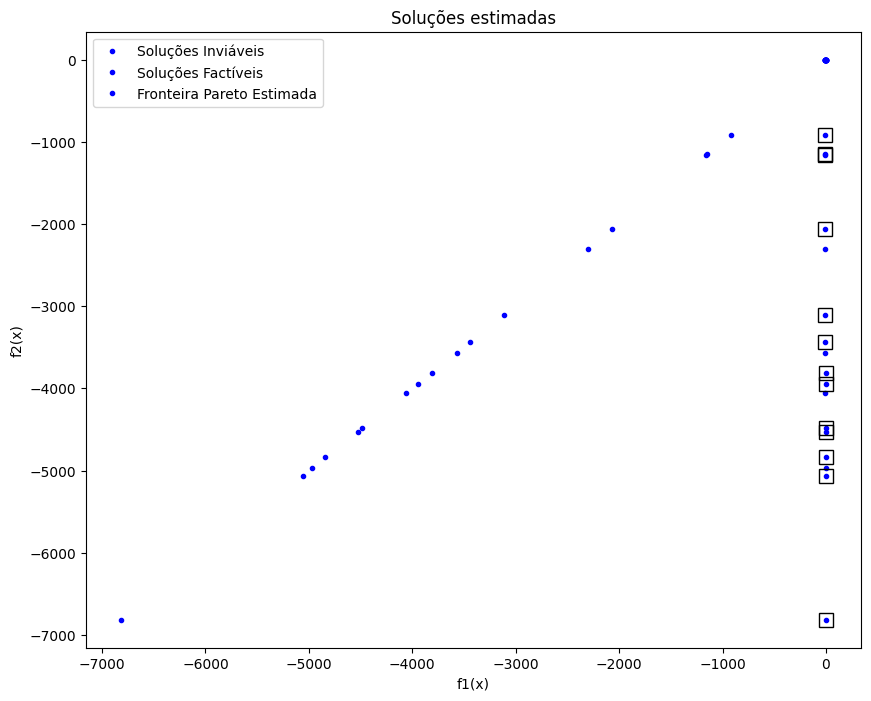

In [243]:
f = np.array(archive.fitpen)
F = copy.deepcopy(f)        # faz uma cópia somente das soluções viáveis
NDindex = nondominatedsolutions(F)     

plt.figure(figsize=(10,8))
plt.plot(f[:,0],f[:,1],'b.')
plt.plot(f[g<=0,0],f[g<=0,1],'r.')
plt.plot(F[NDindex==1,0],F[NDindex==1,1],'ks',markerfacecolor='none',markersize=10)    
plt.legend(['Soluções Factíveis', 'Soluções Inviáveis', 'Fronteira Pareto Estimada'])
plt.title('Soluções estimadas')
plt.xlabel('f1(x)')
plt.ylabel('f2(x)')
plt.show()
    
plt.figure(figsize=(10,8))


plt.plot(-f[:,0],-f[:,1],'b.')
plt.plot(-f,-f,'b.')     
plt.plot(-F[NDindex==1,0],-F[NDindex==1,1],'ks',markerfacecolor='none',markersize=10)
plt.legend(['Soluções Inviáveis', 'Soluções Factíveis', 'Fronteira Pareto Estimada'])
plt.title('Soluções estimadas')
plt.xlabel('f1(x)')
plt.ylabel('f2(x)')
plt.show()